## Approach

* This is a simplied version of YOLO. The input image is 512x512. YOLO was intended to train on images which all contained at least one object, most multiple objects. The architecture and loss functions have been adapted for this case, where not every image contains an object and there are at most 4 ROIs per image. 
* Since the maximum number of ROIs in each image is 4 we decided to use a 2x2 grid to simplify the network. In the case where multiple ROIs occur in the same cell we combine the ROIs into a single ROI by expanding the box to include both. Each cell outputs five values:
    * The confidence that there is pneumonia present
    * The x, y, w, and h of the bounding box
    * We have removed the entire classification section, using the confidence to indicate whether there is an ROI in the cell instead.
* A sigmoid is applied to the output of the network to result in values between 0 and 1    
* The x and y coordinates are offsets from the upper left corner of each cell, the w and h are percentage of the total width.
* The loss function is based on YOLO with some differences:
    * The weights of the components have been updated
    * The classification loss has been removed.
    * The "objectness" loss of YOLO tries to make the confidence match the actual IOU. Since our model only outputs one box per cell, this doesn't really make any sense and ends up driving the confidence down to the IOU. We replace this by an IOU loss which subtracts the IOU for that cell from 1.

## Network

* The network consists of a number of residual blocks with convolutions and downsampling blocks with max pooling.
* There are two dilated convolutions at the end of the network to provide context.
* The dilated convolutions are followed by two strided convolutions which downsize to 2x2.
* Finally there are a series of 1x1 convolutions which output a 2x2x5 tensor.
* We are using an Adam optimizer with gradient clipping to avoid exploding gradients, which had been a problem.

## Predictions
* To generate our predictions we loop through each cell of the output
* We unnormalize the output to get the actual values
* If the confidence is greater than 0.5 and the box has width and height we append it to the list of candidates.
* We apply non-max suppression to remove duplicates.
* The remaining boxes are concatenated onto the output string.

**Change Log:**
* v3 - changing output to 8x8 grid from 16x16; changed model to downsample one more time; adjusted network accordingly. 
* v4 - changed output to 4x4 grid, no image has more than 3 ROIs so this may work better? 
    * Using center point of ROI to predict instead of upper left corner.
* v5 - We only calculate MSE loss for boxes with a confidence over 0.5 or actual truth since we don't care about predictions for boxes that are not ROIs. This will prevent the network from being constrained by outputting 0s for boxes that don't exist.
* v6 - centering input data so maybe bboxes can be output more accurately? Also centering the image
* v6.2 - labels have ROI centered in center of cell by default instead of mean location.
* v8 - using custom loss function based on YOLO loss. Set default height and width to 1 px because 0 sent the gradients to -inf which screwed everything up.
* v10 - using 2x2 grid as output
* v12 - changing layout of model slightly - replaced final pools with convs with strides; reduced number of params; ensure that there is at least one positive image per batch.
* v13 - tweaking architecture slightly.
* v14 - going to 5x5 grid
* v15 - downsizing with average and max pool followed by 1x1 convolutions

In [1]:
import os
import csv
import random
import pydicom
import numpy as np
import pickle
import pandas as pd
from skimage import measure
from skimage.transform import resize
import datetime
import math

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [2]:
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh=0.3):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    # initialize the list of picked indexes	
    pick = []
 
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    w = boxes[:,2]
    h = boxes[:,3]
 
    x2 = x1 + w
    y2 = y1 + h

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (w + 1) * (h + 1)
    idxs = np.argsort(y2)
 
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
 
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
 
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
 
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

# get actual x and y values from sigmoid output and what cell they are in
def unnorm(val, idx, cell_size=256):
    x = (val * cell_size) + (cell_size * idx)
    return x

# sigmoid in numpy, with limit to avoid nans                             
def sigmoid(x):
    # to avoid NaNs set a lower floor on x values
    y = np.maximum(x, -700)
    return 1 / (1 + np.exp(-y))    

# adjust contrast of image
def change_contrast(img, contrast_factor):
    mean = np.mean(img)
    img = (img - mean) * contrast_factor + mean
    return img

In [3]:
# enter your Kaggle credentionals here
os.environ['KAGGLE_USERNAME']="skooch"
os.environ['KAGGLE_KEY']="42f8a02ee92cc773d1dbe66565673ad3"

# Load pneumonia locations

Table contains [filename : pneumonia location] pairs per row. 
* If a filename contains multiple pneumonia, the table contains multiple rows with the same filename but different pneumonia locations. 
* If a filename contains no pneumonia it contains a single row with an empty pneumonia location.

The code below loads the table and transforms it into a dictionary. 
* The dictionary uses the filename as key and a list of pneumonia locations in that filename as value. 
* If a filename is not present in the dictionary it means that it contains no pneumonia.

In [4]:
ROOT_DIR = "./"

train_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_test_images')
print("Train dir:", train_dicom_dir)

Train dir: ./stage_1_train_images


In [21]:
with open('yolo_labels_centered_5x5_8b.p', 'rb') as handle:
    pneumonia_locations = pickle.load(handle)

# Load filenames

In [6]:
random.seed(17)

# load and shuffle filenames
folder = './stage_1_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = int(len(filenames) * 0.1)
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 23116
n valid samples 2568


In [7]:
positive_images = []

for filename in pneumonia_locations:
    label = pneumonia_locations[filename][...,0]
    if np.max(label) > 1e-6:
        if filename + ".dcm" in train_filenames:
            positive_images.append(filename + ".dcm")

 # Data generator

The dataset is too large to fit into memory, so we need to create a generator that loads data on the fly.

* The generator takes in some filenames, batch_size and other parameters.

* The generator outputs a random batch of numpy images and numpy masks.
    

In [8]:
BATCH_SIZE = 16
IMAGE_SIZE = 480
CHECKPOINT_PATH = "yolo15_1_480.h5"

In [9]:
# means to center data
mu_x = 391.456158
mu_y = 363.1358768
mu_w = 220.8453815
mu_h = 334.1743641
mu_center_x = 501.8788487
mu_center_y = 530.2230589

In [10]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
    
    def augment_imgs(self, img, confs, boxes):
        # flip the image half the time
        if random.random() > 0.5:
            img = np.fliplr(img)
            
            # update our x coords
            mask = confs != 0
            
            # flip
            boxes[mask, 0] = 1 - boxes[mask,0]
            
            # flip our boxes lr on axis 0
            boxes = np.flip(boxes, axis=0)         
            
            # flip the confidences lr as well
            confs = np.flip(confs, axis=0)
            
        ## small random shifts
        h_offset = np.random.randint(low=0, high=5)
        v_offset = np.random.randint(low=0, high=5)

        # crop the images
        img = img[v_offset:,h_offset:]
           
        ## adjust contrast half the time
        if random.random() > 0.5:  
            # generate a random contrast adjustment
            contrast_factor = np.random.normal(loc=1.0, scale=0.10)
            
            # put some limits on the contrast
            contrast_factor = np.minimum(contrast_factor, 1.25)
            contrast_factor = np.maximum(contrast_factor, 0.75)
            
            # adjust the image
            img = change_contrast(img, contrast_factor)
            
        return img, confs, boxes
            
            
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # get filename without extension
        filename = filename.split('.')[0]
        label = pneumonia_locations[filename].copy()
        
        # remove the confidence and bboxes because they will be flipped separately
        confs = label[:,:,0]
        boxes = label[:,:,1:]
        
        ## augment the data with flips, small shifts and contrast adjustment
        if self.augment:
            img, confs, boxes = self.augment_imgs(img, confs, boxes)
            
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        
        # scale and center the image
        img = (img - np.mean(img)) / np.max(img)
        
        boxes = np.concatenate([confs.reshape((5,5,1)), boxes], axis=2)
        
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img, boxes
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            
            # unzip images and masks
            imgs, bboxes = zip(*items)
            
            # create numpy batch
            imgs = np.array(imgs)
            bboxes = np.array(bboxes)
            
            # make sure there is at least one positive image in the batch
            pos = np.max(bboxes[:,:,:,0])
            if pos < 1:
                # pick a random positive image
                filename = np.random.choice(positive_images)
                img, label = self.__load__(filename)
                
                # add the positive image to our batch
                imgs[-1] = img
                bboxes[-1] = label
                
            labels = bboxes
            return imgs, labels
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [11]:
# train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)

# counter = 0
# for imgs, labels in train_gen:
#     for label in labels:
#         for i in range(4):
#             for j in range(4):
#                 if label[i,j,0] == 1:
#                     if label[i,j,4] ==  0.001:
#                         print("Error!")
#     counter += 1
#     if counter > 15:
#         break

# Network

In [22]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0.1)(x)
    x_1 = keras.layers.MaxPool2D(2)(x)
    x_2 = keras.layers.AveragePooling2D(2)(x)
    x = keras.layers.concatenate([x_1, x_2])
    x = keras.layers.Conv2D(channels, 1, padding="same", use_bias=False)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0.1)(x)
    x_1 = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x_1)
    x = keras.layers.LeakyReLU(0.1)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
#     x = keras.layers.add([x, inputs])
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.add([x, x_1])
    return x

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input - 512x512x3
    inputs = keras.Input(shape=(input_size, input_size, 1))
    
    # downsample to 256x256x24
    x = keras.layers.Conv2D(channels, 3, strides=(2,2), padding='same', use_bias=False)(inputs)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
#     x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
#     x = keras.layers.BatchNormalization(momentum=0.9)(x)
#     x = keras.layers.LeakyReLU(0.1)(x)
    
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    x = keras.layers.Conv2D(channels * 2, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    # residual blocks
    for d in range(depth):
        
        channels = channels * 2
        
        x = create_downsample(channels, x)
        
        for b in range(n_blocks):
            x = create_resblock(channels, x)
        
    x_2 = x
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    # dilated convolutions for context - 15x15x512
    x = keras.layers.Conv2D(channels, (3,3), padding='same', dilation_rate=(2,2), activation=None, name="dilated_conv_1")(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
        
    x = keras.layers.Conv2D(channels, (3,3), padding='same', dilation_rate=(2,2), activation=None, name="dilated_conv_2")(x)
    x = keras.layers.add([x, x_2])
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    x = keras.layers.Conv2D(512, (3,3), padding='same', strides=(1,1), activation=None, name="last_conv")(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    # downsample to 8x8 with stride 2
    x = keras.layers.Conv2D(512, (3,3), padding='same', strides=(3,3), activation=None, name="downsample_1")(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    x = keras.layers.Dropout(0.10)(x)
    
    # bounding box branch
    b = keras.layers.Conv2D(1024, (1,1), padding='same', activation=None, name="fc_1_b", kernel_regularizer=keras.regularizers.l2(l=0.005))(x)
    b = keras.layers.BatchNormalization(momentum=0.9)(b)
    b = keras.layers.LeakyReLU(0.01)(b)
    b = keras.layers.Dropout(0.10)(b)
    
    b = keras.layers.Conv2D(1024, (1,1), padding='same', activation=None, name="fc_2_b", kernel_regularizer=keras.regularizers.l2(l=0.001))(x)
    b = keras.layers.BatchNormalization(momentum=0.9)(b)
    b = keras.layers.LeakyReLU(0.01)(b)
    
    boxes = keras.layers.Conv2D(5, (1,1), padding='same', activation="linear")(b)
#     boxes = keras.layers.concatenate([confidence, boxes], name="bboxes_output")
    
    # return both outputs
    model = keras.Model(inputs=inputs, outputs=boxes)
    
    return model

# Train network


In [23]:
# after each epoch run our function to calculate the actual IOU for half of the validation images. 
# I was not able to figure out how to implement this in tensorflow since I don't think we can iterate
# through tensors. So we do it as a callback instead. Hopefully this will approximate the actual IOU score.
class Calc_IOU_CB(keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        valid_gen2 = generator(folder, valid_filenames, pneumonia_locations, batch_size=32, image_size=IMAGE_SIZE, shuffle=True, predict=False)
        ious = []
        counter = 0
        for imgs, labels in valid_gen2:
            preds = self.model.predict(imgs)
            iou = overlap_iou2(labels, preds)
            ious.append(iou)
            counter += BATCH_SIZE
            
            if counter > 900:
                break
            
        print("Epoch", epoch, ": Mean IOU:", np.mean(ious))
        
        return

In [24]:
GRID_SIZE = 5
CELL_SIZE = 1024 / GRID_SIZE

def binary_accuracy(y_true, y_pred):
    # apply sigmoid to our predictions
    y_pred = tf.sigmoid(y_pred)
    # round both since our negative truths are 1e-16 instead of 0
    y_true = tf.round(tf.reshape(y_true, [-1, 5]))
    y_pred = tf.round(tf.reshape(y_pred, [-1, 5]))
    
    acc = tf.reduce_mean(tf.cast(tf.equal(y_true[:,0], y_pred[:,0]), dtype=tf.float32))
    return acc

def overlap_iou(y_true, y_pred):
    """
    Args:
        bboxes1: shape (batch_size, 16, 16, 4)
            with x1, y1, x2, y2 point order.
        bboxes2: shape (batch_size, 16, 16, 4)
            with x1, y1, x2, y2 point order.
        p1 *-----
           |     |
           |_____* p2
    Returns:
        Tensor with shape (total_bboxes1, total_bboxes2)
        with the IoU (intersection over union) of bboxes1[i] and bboxes2[j]
        in [i, j].
    """
    y_pred = tf.sigmoid(y_pred)
    
    # flatten the data because it's easier that way
    bboxes1 = tf.reshape(y_true, (-1, 5))
    bboxes2 = tf.reshape(y_pred, (-1, 5))
    
    # split the components out
    true_boxes, x11, y11, w1, h1 = tf.split(bboxes1, 5, axis=1)
    pred_conf, x21, y21, w2, h2 = tf.split(bboxes2, 5, axis=1)
    
    # uncenter the data - make sure the numbers are positive
    x11 = x11 * CELL_SIZE
    x21 = x21 * CELL_SIZE
    y11 = y11 * CELL_SIZE
    y21 = y21 * CELL_SIZE
    
    w1 = w1 * 1024
    w2 = w2 * 1024
    h1 = h1 * 1024
    h2 = h2 * 1024
    
    # is there either a box predicted here or a box actually here?
    mask = (pred_conf >= 0.5) | (true_boxes == 1)
    
    # get the far corners of the boxes
    x12 = x11 + (w1 / 2)
    y12 = y11 + (h1 / 2)
    x22 = x21 + (w2 / 2)
    y22 = y21 + (h2 / 2)
    
    x11 = x11 - (w1 / 2)
    y11 = y11 - (h1 / 2)
    x21 = x21 - (w2 / 2)
    y21 = y21 - (h2 / 2)

    # find the corners of the intersection area
    xI1 = tf.maximum(x11, x21)
    yI1 = tf.maximum(y11, y21)

    xI2 = tf.minimum(x12, x22)
    yI2 = tf.minimum(y12, y22)
    
    # get the intersection area, if the truth has no boxes it is 0
    inter_area = true_boxes * (xI2 - xI1 + 1) * (yI2 - yI1 + 1)

    # get the area of each box
    bboxes1_area = (w1 + 1) * (h1 + 1)
    bboxes2_area = (w2 + 1) * (h2 + 1)
    
    # union is area of both boxes - intersection
    union = (bboxes1_area + bboxes2_area) - inter_area + 1
    
    iou = tf.maximum(inter_area/(union + 1e-6), 0)
    
    # apply the mask
    iou = tf.boolean_mask(iou, mask)
    
    # reduce the mean so we have mean iou for our inputs
    return tf.reduce_mean(iou)

def overlap_iou2(y_true, y_pred):
    """
    Args:
        y_true and y_pred - arrays of boxes containing center points, h and w of boxes
        p1 *-----
           |     |
           |_____* p2
    Returns:
        Average IOU over boxes
    """
    OVERLAP = 0.3
    
    # apply the sigmoid
    y_pred = sigmoid(y_pred)
    
    ious = []
    
    # loop over both sets of boxes
    for truth, pred in zip(y_true, y_pred):
        # get true area
        true_area = 0
        true_boxes = []
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                c, x, y, w, h = truth[i,j,:]
                # if we have an ROI
                if c == 1:
                    # unnormalize the data
                    w, h = w*1024, h*1024
                    true_area += w * h
                    
                    # unnormalize the x and y
                    x = unnorm(x, j, CELL_SIZE)
                    y = unnorm(y, i, CELL_SIZE)
                    
                    true_boxes.append([x, y, x+w, y+h])
                    
        pred_area = 0
        pred_boxes = []
        # get the predicted area
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                c, x, y, w, h = pred[i,j,:]
                # if we have an ROI
                if c > 0.5:
                    # unnormalize the data
                    w, h = w*1024, h*1024
                    pred_area += w * h
                    
                    # unnormalize the x and y
                    x = unnorm(x, j, CELL_SIZE)
                    y = unnorm(y, i, CELL_SIZE)
                    
                    pred_boxes.append([x, y, x+w, y+h])
            
        intersect_area = 0
        
        # non-max suppression?
        pred_boxes = non_max_suppression_fast(np.array(pred_boxes), OVERLAP)
        
        # get the intersection
        for pred_box in pred_boxes:
            x1_p, y1_p, x2_p, y2_p = pred_box
            
            for true_box in true_boxes:
                x1_t, y1_t, x2_t, y2_t = true_box
                
                # if the boxes overlap at all
                if (x1_p >= x1_t and y1_p >= y1_t) or (x1_p <= x1_t and y1_p <= y1_t):
                    # get the intersection corners
                    x1_i = np.maximum(x1_p, x1_t)
                    y1_i = np.maximum(y1_p, y1_t)
                    x2_i = np.minimum(x2_p, x2_t)
                    y2_i = np.minimum(y2_p, y2_t)
                    
                    # get area of intersect
                    i_w, i_h = x2_i - x1_i, y2_i - y1_i

                    # trap for negative numbers
                    i_w = np.maximum(i_w, 0)
                    i_h = np.maximum(i_h, 0)

                    intersection = i_w * i_h
                    intersect_area += intersection

        union = true_area + pred_area - intersect_area
        
        iou = intersect_area / (union + 1e-16)
        
        # only count the IOU if there are truths or predictions
        if len(true_boxes) or len(pred_boxes):
            ious.append(iou)
    
    iou_area = np.mean(ious)
    return iou_area
                    
def loss_fn(y_true, y_pred):
    # get the iou loss
    iou_loss = iou_loss_fn(y_true, y_pred)
    
    # get the xe loss
    xe_loss = binary_cross_entropy(y_true, y_pred)
    
    # get the box loss
    box_loss = adj_mse(y_true, y_pred)
    
    # add the losses and return them
    return (1.0 * xe_loss) + (box_loss * 3.0) + (iou_loss * 4.0)

# only apply mse to layers with high confidence that there is an ROI or if there actually is an ROI
def adj_mse(y_true, y_pred):
    # coefficients
    lam_coord = 5
    lam_noobj = 0.5
    
    y_pred = tf.sigmoid(y_pred)
        
    # flatten the inputs
    y_true = tf.reshape(y_true, (-1, 5))
    y_pred = tf.reshape(y_pred, (-1, 5))

    # separate the confidence from the boxes
    conf_true, x_true, y_true, w_true, h_true = tf.split(y_true, 5, axis=1)
    conf_pred, x_pred, y_pred, w_pred, h_pred = tf.split(y_pred, 5, axis=1)

    # center squared error
    center_se = tf.square(x_true - y_pred) + tf.square(y_true - y_pred)
    size_se =  tf.square(tf.sqrt(w_true) - tf.sqrt(w_pred)) + tf.square(tf.sqrt(h_true) - tf.sqrt(h_pred))
    
    box_se = center_se + size_se
    
    # only get loss for boxes which are actually positive
    mask = tf.equal(conf_true, 1)
    box_se = tf.boolean_mask(box_se, mask)
    
    # weight the loss higher
    box_se = tf.multiply(box_se, 5.0)
    
    loss = tf.reduce_sum(box_se)
    
    return loss
    
# use weight of 0.5 for negative cells, 19 for positive ones
def binary_cross_entropy(y_true, y_pred):
    conf_true = y_true[...,0]
    conf_pred = tf.sigmoid(y_pred[...,0])
    
    weight = 10.5
    weights = tf.multiply(y_true[...,0], weight) + 0.5
    
    xe = tf.multiply(tf.square(conf_true - conf_pred), weights)
    
    return tf.reduce_sum(xe)

def objectness_loss_fn(y_true, y_pred):
    y_pred = tf.sigmoid(y_pred)
    
    # pred box conf
    pred_box_conf = y_pred[...,0]
    
    # separate the x, y from the w, h
    true_box_xy = y_true[...,1:3] * CELL_SIZE
    true_box_wh = y_true[...,3:] * 1024
    
    pred_box_xy = y_pred[...,1:3] * CELL_SIZE
    pred_box_wh = y_pred[...,3:] * 1024
    
    # get the corners of the boxes by subtracting or adding half of h, w
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half  
    
    # get the corners of the intersect area
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas + 1e-16)
    
    true_box_conf = iou_scores * y_true[..., 0]
    
    conf_mask  = tf.zeros_like(iou_scores)
    conf_mask = conf_mask + tf.cast((iou_scores < 0.6), dtype=tf.float32) * (1 - y_true[...,0])
    conf_mask = conf_mask + y_true[..., 0] * 5.0
    
    nb_conf_box  = tf.reduce_sum(tf.cast((conf_mask > 0.0), dtype=tf.float32)) 
    
    loss_conf  =  tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box + 1e-6) / 2.
    
    return tf.reduce_sum(loss_conf)

def iou_loss_fn(y_true, y_pred):
    # apply sigmoid to predictions
    y_pred = tf.sigmoid(y_pred)
    
    # separate the x, y from the w, h and unnormalize them
    true_box_xy = y_true[...,1:3] * CELL_SIZE
    true_box_wh = y_true[...,3:] * 1024
    
    pred_box_xy = y_pred[...,1:3] * CELL_SIZE
    pred_box_wh = y_pred[...,3:] * 1024
    
    # get the corners of the boxes by subtracting or adding half of h, w
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half  
    
    # get the corners of the intersect area
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    # get the area of the boxes
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    # calculate the IOU
    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas + 1e-16)
    
    # only use the IOU from boxes which actually have ROIs
    mask = tf.equal(y_true[...,0], 1)
    use_iou = tf.boolean_mask(1 - iou_scores, mask)
    
    return tf.reduce_sum(use_iou)
    
# create network and compiler
model = create_network(input_size=IMAGE_SIZE, channels=24, n_blocks=1, depth=4)

optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=1e-7, clipnorm=2.0, clipvalue=0.75)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=[binary_accuracy, overlap_iou, adj_mse, binary_cross_entropy])

# cosine learning rate annealing
def exp_decay(x):
    lr0 = 0.005
    epochs_drop = 10
    drop = 0.85
    lrate = lr0 * math.pow(drop, math.floor((1+x)/epochs_drop))
    return lrate

learning_rate = tf.keras.callbacks.LearningRateScheduler(exp_decay)
checkpoint = keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)
calc_iou = Calc_IOU_CB()

# create train and validation generators
folder = './stage_1_train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 480, 480, 1)  0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 240, 240, 24) 216         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 240, 240, 24) 96          conv2d_25[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_31 (LeakyReLU)      (None, 240, 240, 24) 0           batch_normalization_31[0][0]     
__________________________________________________________________________________________________
conv2d_26 

In [26]:
model.load_weights(CHECKPOINT_PATH)

In [21]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=10, shuffle=True, verbose=1, initial_epoch=0)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 1/10
1443/1444 [============================>.] - ETA: 0s - loss: 133.6218 - binary_accuracy: 0.8575 - overlap_iou: nan - adj_mse: 15.5245 - binary_cross_entropy: 75.0231
Epoch 00001: saving model to yolo15_1_480.h5
1444/1444 [==============================] - 1236s 856ms/step - loss: 133.5752 - binary_accuracy: 0.8574 - overlap_iou: nan - adj_mse: 15.5169 - binary_cross_entropy: 75.0027 - val_loss: 91.4035 - val_binary_accuracy: 0.7685 - val_overlap_iou: 0.0175 - val_adj_mse: 7.0194 - val_binary_cross_entropy: 60.8518
Epoch 2/10
1443/1444 [============================>.] - ETA: 0s - loss: 85.3483 - binary_accuracy: 0.8566 - overlap_iou: 0.0240 - adj_mse: 6.7986 - binary_cross_entropy: 55.8133
Epoch 00002: saving model to yolo15_1_480.h5
1444/1444 [==============================] - 1221s 845ms/step - loss: 85.3089 - binary_accuracy: 0.8566 - overlap_iou: 0.0240 - adj_mse: 6.7951 - binary_cross_entropy: 55.7879 - val_loss: 74.1052 - val_binary_accuracy: 0.8857 - val_overlap_iou: 0

In [30]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=15, shuffle=True, verbose=1, initial_epoch=10)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 11/15
1443/1444 [============================>.] - ETA: 0s - loss: 46.3788 - binary_accuracy: 0.9002 - overlap_iou: 0.0489 - adj_mse: 4.2172 - binary_cross_entropy: 27.2734
Epoch 00011: saving model to yolo15_1_480.h5
1444/1444 [==============================] - 1230s 852ms/step - loss: 46.3608 - binary_accuracy: 0.9002 - overlap_iou: 0.0489 - adj_mse: 4.2153 - binary_cross_entropy: 27.2637 - val_loss: 44.2124 - val_binary_accuracy: 0.9206 - val_overlap_iou: 0.0622 - val_adj_mse: 4.2039 - val_binary_cross_entropy: 25.2940
Epoch 12/15
1443/1444 [============================>.] - ETA: 0s - loss: 45.0904 - binary_accuracy: 0.9019 - overlap_iou: 0.0510 - adj_mse: 4.1422 - binary_cross_entropy: 26.2491
Epoch 00012: saving model to yolo15_1_480.h5
1444/1444 [==============================] - 1204s 834ms/step - loss: 45.0789 - binary_accuracy: 0.9019 - overlap_iou: 0.0510 - adj_mse: 4.1405 - binary_cross_entropy: 26.2457 - val_loss: 44.4104 - val_binary_accuracy: 0.9020 - val_overlap_io

In [16]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=20, shuffle=True, verbose=1, initial_epoch=15)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 16/20
1443/1444 [============================>.] - ETA: 1s - loss: 39.7609 - binary_accuracy: 0.9201 - overlap_iou: 0.0645 - adj_mse: 3.9109 - binary_cross_entropy: 21.8487
Epoch 00016: saving model to yolo15_1_480.h5
1444/1444 [==============================] - 2016s 1s/step - loss: 39.7777 - binary_accuracy: 0.9201 - overlap_iou: 0.0645 - adj_mse: 3.9139 - binary_cross_entropy: 21.8537 - val_loss: 38.3951 - val_binary_accuracy: 0.9253 - val_overlap_iou: 0.0720 - val_adj_mse: 3.8206 - val_binary_cross_entropy: 20.8554
Epoch 17/20
1443/1444 [============================>.] - ETA: 0s - loss: 39.2718 - binary_accuracy: 0.9225 - overlap_iou: 0.0667 - adj_mse: 3.8243 - binary_cross_entropy: 21.6262
Epoch 00017: saving model to yolo15_1_480.h5
1444/1444 [==============================] - 1206s 835ms/step - loss: 39.2848 - binary_accuracy: 0.9225 - overlap_iou: 0.0667 - adj_mse: 3.8252 - binary_cross_entropy: 21.6342 - val_loss: 39.6139 - val_binary_accuracy: 0.9349 - val_overlap_iou: 

In [21]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=25, shuffle=True, verbose=1, initial_epoch=20)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 21/25
1443/1444 [============================>.] - ETA: 0s - loss: 34.9413 - binary_accuracy: 0.9371 - overlap_iou: 0.0839 - adj_mse: 3.6317 - binary_cross_entropy: 18.2131
Epoch 00021: saving model to yolo15_1_480.h5
1444/1444 [==============================] - 1238s 857ms/step - loss: 34.9310 - binary_accuracy: 0.9371 - overlap_iou: 0.0838 - adj_mse: 3.6299 - binary_cross_entropy: 18.2108 - val_loss: 34.4658 - val_binary_accuracy: 0.9483 - val_overlap_iou: 0.1015 - val_adj_mse: 3.6836 - val_binary_cross_entropy: 17.6724
Epoch 22/25
1443/1444 [============================>.] - ETA: 0s - loss: 34.6566 - binary_accuracy: 0.9388 - overlap_iou: 0.0859 - adj_mse: 3.6178 - binary_cross_entropy: 17.9777
Epoch 00022: saving model to yolo15_1_480.h5
1444/1444 [==============================] - 1229s 851ms/step - loss: 34.6450 - binary_accuracy: 0.9388 - overlap_iou: 0.0859 - adj_mse: 3.6163 - binary_cross_entropy: 17.9729 - val_loss: 35.0015 - val_binary_accuracy: 0.9212 - val_overlap_io

In [57]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint, calc_iou], epochs=35, shuffle=True, verbose=1, initial_epoch=28)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 29/35
1443/1444 [============================>.] - ETA: 0s - loss: 33.9566 - binary_accuracy: 0.9492 - overlap_iou: 0.1053 - adj_mse: 3.4769 - binary_cross_entropy: 15.1815
Epoch 00029: saving model to yolo15_1_480.h5
Epoch 28 : Mean IOU: 0.05399510996332618
1444/1444 [==============================] - 1287s 891ms/step - loss: 33.9498 - binary_accuracy: 0.9492 - overlap_iou: 0.1053 - adj_mse: 3.4754 - binary_cross_entropy: 15.1815 - val_loss: 36.3432 - val_binary_accuracy: 0.9483 - val_overlap_iou: 0.1017 - val_adj_mse: 3.7894 - val_binary_cross_entropy: 16.3938
Epoch 30/35
1443/1444 [============================>.] - ETA: 0s - loss: 32.9791 - binary_accuracy: 0.9509 - overlap_iou: 0.1095 - adj_mse: 3.4021 - binary_cross_entropy: 14.5911
Epoch 00030: saving model to yolo15_1_480.h5
Epoch 29 : Mean IOU: 0.04024637460148284
1444/1444 [==============================] - 1244s 862ms/step - loss: 32.9803 - binary_accuracy: 0.9509 - overlap_iou: 0.1095 - adj_mse: 3.4016 - binary_cross_e

In [67]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint, calc_iou], epochs=40, shuffle=True, verbose=1, initial_epoch=36)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 37/40
1443/1444 [============================>.] - ETA: 0s - loss: 32.6035 - binary_accuracy: 0.9591 - overlap_iou: 0.1302 - adj_mse: 3.2962 - binary_cross_entropy: 12.1039
Epoch 00037: saving model to yolo15_1_480.h5
Epoch 36 : Mean IOU: 0.04946622577118343
1444/1444 [==============================] - 1346s 932ms/step - loss: 32.6071 - binary_accuracy: 0.9591 - overlap_iou: 0.1302 - adj_mse: 3.2969 - binary_cross_entropy: 12.1015 - val_loss: 38.3050 - val_binary_accuracy: 0.9619 - val_overlap_iou: 0.1333 - val_adj_mse: 3.5963 - val_binary_cross_entropy: 16.7639
Epoch 38/40
1443/1444 [============================>.] - ETA: 0s - loss: 32.2222 - binary_accuracy: 0.9607 - overlap_iou: 0.1339 - adj_mse: 3.2725 - binary_cross_entropy: 11.8331
Epoch 00038: saving model to yolo15_1_480.h5
Epoch 37 : Mean IOU: 0.04168733591954147
1444/1444 [==============================] - 1298s 899ms/step - loss: 32.2457 - binary_accuracy: 0.9607 - overlap_iou: 0.1340 - adj_mse: 3.2758 - binary_cross_e

In [27]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint, calc_iou], epochs=50, shuffle=True, verbose=1, initial_epoch=43)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 44/50
1443/1444 [============================>.] - ETA: 1s - loss: 30.6676 - binary_accuracy: 0.9666 - overlap_iou: 0.1569 - adj_mse: 3.2209 - binary_cross_entropy: 10.6014
Epoch 00044: saving model to yolo15_1_480.h5
Epoch 43 : Mean IOU: 0.05266312651932636
1444/1444 [==============================] - 2004s 1s/step - loss: 30.6536 - binary_accuracy: 0.9666 - overlap_iou: 0.1569 - adj_mse: 3.2190 - binary_cross_entropy: 10.5979 - val_loss: 40.6477 - val_binary_accuracy: 0.9657 - val_overlap_iou: 0.1396 - val_adj_mse: 3.5983 - val_binary_cross_entropy: 19.0734
Epoch 45/50
1443/1444 [============================>.] - ETA: 0s - loss: 30.7275 - binary_accuracy: 0.9666 - overlap_iou: 0.1553 - adj_mse: 3.2313 - binary_cross_entropy: 10.5958
Epoch 00045: saving model to yolo15_1_480.h5
Epoch 44 : Mean IOU: 0.05162782353340777
1444/1444 [==============================] - 1284s 889ms/step - loss: 30.7270 - binary_accuracy: 0.9666 - overlap_iou: 0.1553 - adj_mse: 3.2308 - binary_cross_entr

/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


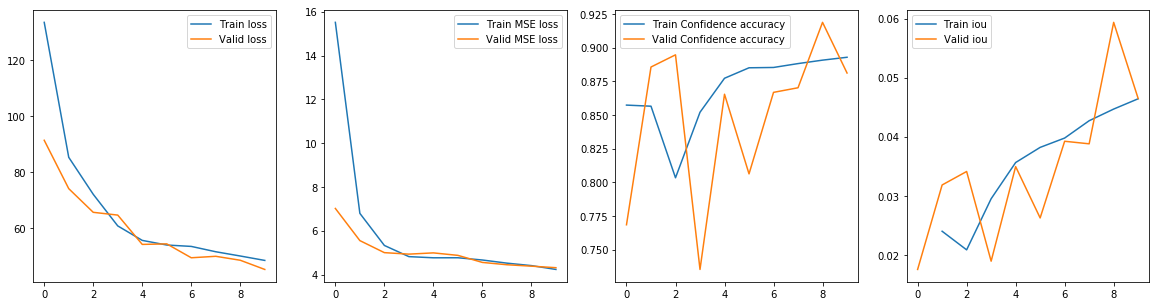

In [22]:
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(142)
plt.plot(history.epoch, history.history["adj_mse"], label="Train MSE loss")
plt.plot(history.epoch, history.history["val_adj_mse"], label="Valid MSE loss")
plt.legend()
plt.subplot(143)
plt.plot(history.epoch, history.history["binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(144)
plt.plot(history.epoch, history.history["overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


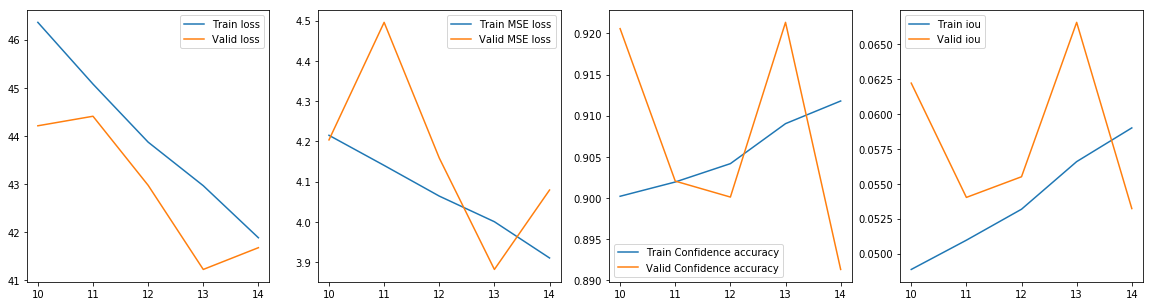

In [31]:
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(142)
plt.plot(history.epoch, history.history["adj_mse"], label="Train MSE loss")
plt.plot(history.epoch, history.history["val_adj_mse"], label="Valid MSE loss")
plt.legend()
plt.subplot(143)
plt.plot(history.epoch, history.history["binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(144)
plt.plot(history.epoch, history.history["overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


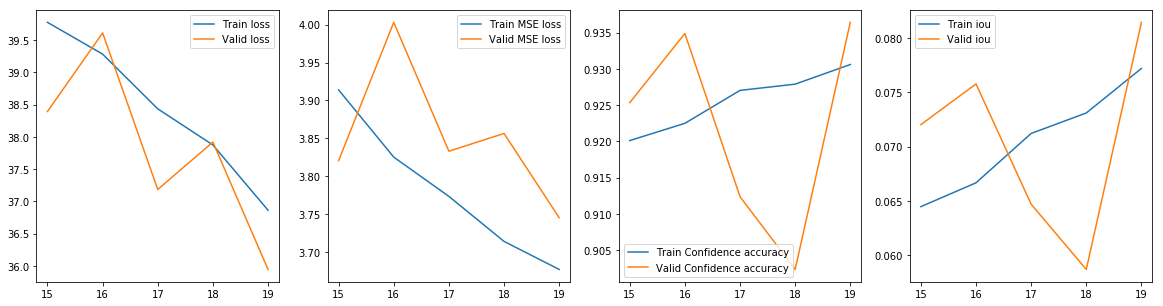

In [17]:
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(142)
plt.plot(history.epoch, history.history["adj_mse"], label="Train MSE loss")
plt.plot(history.epoch, history.history["val_adj_mse"], label="Valid MSE loss")
plt.legend()
plt.subplot(143)
plt.plot(history.epoch, history.history["binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(144)
plt.plot(history.epoch, history.history["overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

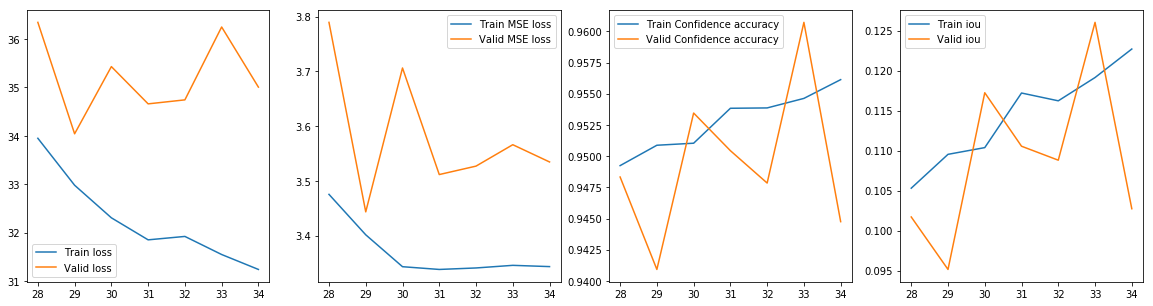

In [58]:
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(142)
plt.plot(history.epoch, history.history["adj_mse"], label="Train MSE loss")
plt.plot(history.epoch, history.history["val_adj_mse"], label="Valid MSE loss")
plt.legend()
plt.subplot(143)
plt.plot(history.epoch, history.history["binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(144)
plt.plot(history.epoch, history.history["overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

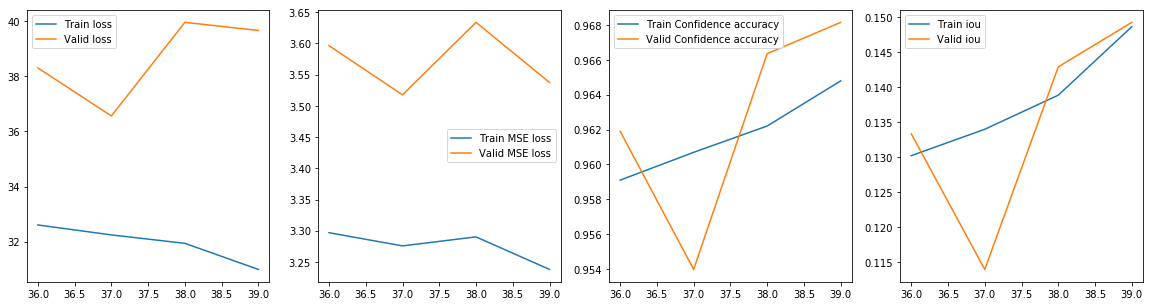

In [68]:
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(142)
plt.plot(history.epoch, history.history["adj_mse"], label="Train MSE loss")
plt.plot(history.epoch, history.history["val_adj_mse"], label="Valid MSE loss")
plt.legend()
plt.subplot(143)
plt.plot(history.epoch, history.history["binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(144)
plt.plot(history.epoch, history.history["overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(142)
plt.plot(history.epoch, history.history["adj_mse"], label="Train MSE loss")
plt.plot(history.epoch, history.history["val_adj_mse"], label="Valid MSE loss")
plt.legend()
plt.subplot(143)
plt.plot(history.epoch, history.history["binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(144)
plt.plot(history.epoch, history.history["overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

## Sample Predictions

In [46]:
model.metrics_names

['loss', 'binary_accuracy', 'overlap_iou', 'adj_mse', 'binary_cross_entropy']

In [54]:
mses = []
problem_names = []

# find which images are causing the high mse loss
for filename in valid_filenames[:20]:    
    # load and resize the image
    img = pydicom.dcmread(os.path.join(train_dicom_dir, filename)).pixel_array
    img = resize(img, (IMAGE_SIZE, IMAGE_SIZE), mode='reflect')
    
    # get the label
    filename = filename.split('.')[0]
    label = pneumonia_locations[filename]
    # predict the image
    loss = model.evaluate(img.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1), label.reshape(1, GRID_SIZE, GRID_SIZE, 5), verbose=0)
    mses.append(loss[3])
    if loss[3] > 10:
        print(filename, "Score:", loss)
        problem_names.append(filename + ".dcm")

/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


52188e35-d9e9-47de-a3c9-71a22f5de52c Score: [151115.109375, 0.9200000166893005, nan, 13.021684646606445, 41.0]


/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Pred: 2 3 conf: 0.9331053 563 214 271 531
True: 0 Pred: 143901 Intersect: 0
IOU: 0.0


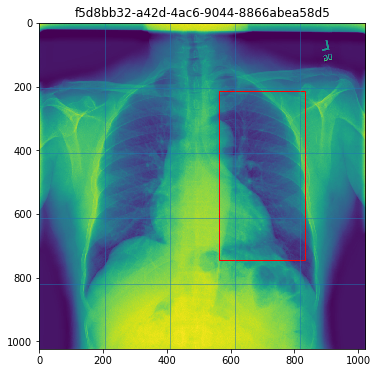

Truth: 2 1 205 301 225 523
Truth: 2 4 673 301 302 607
True: 300989 Pred: 0 Intersect: 0
IOU: 0.0


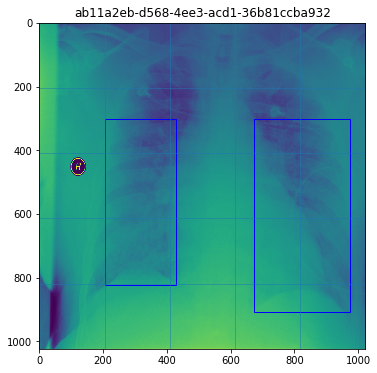

Pred: 2 2 conf: 0.9392881 328 228 251 518
True: 0 Pred: 130018 Intersect: 0
IOU: 0.0


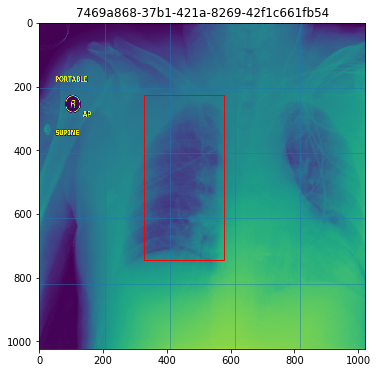

Pred: 1 1 conf: 0.93689686 195 110 254 458
Pred: 2 3 conf: 0.9539461 582 243 259 449
True: 0 Pred: 232623 Intersect: 0
IOU: 0.0


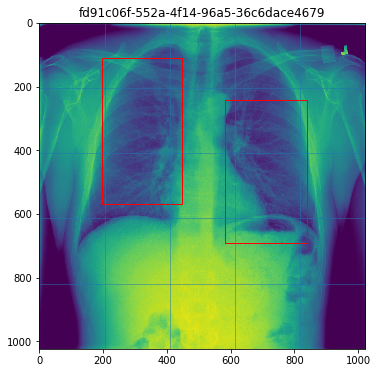

Pred: 1 3 conf: 0.938324 657 118 252 473
Pred: 2 3 conf: 0.9359783 638 324 236 326
True: 0 Pred: 76936 Intersect: 0
IOU: 0.0


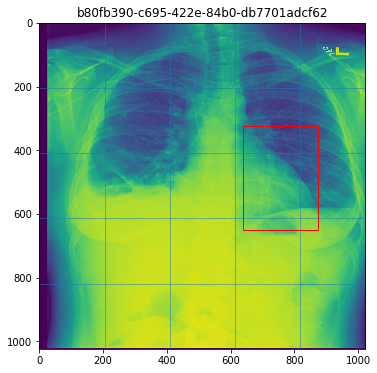

Pred: 2 3 conf: 0.9455055 627 289 250 408
True: 0 Pred: 102000 Intersect: 0
IOU: 0.0


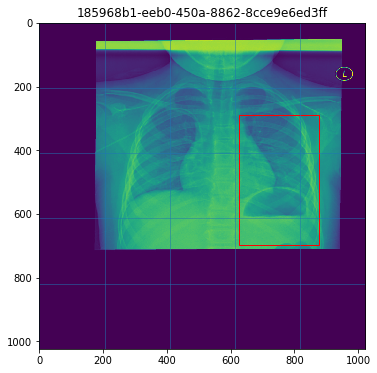

Pred: 2 3 conf: 0.9588709 624 229 279 629
True: 0 Pred: 175491 Intersect: 0
IOU: 0.0


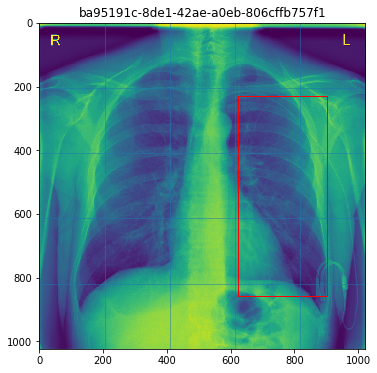

Truth: 2 3 585 140 314 783
Pred: 2 3 conf: 0.9748253 587 168 277 631
True: 245862 Pred: 174787 Intersect: 174787
IOU: 0.7109150661724426


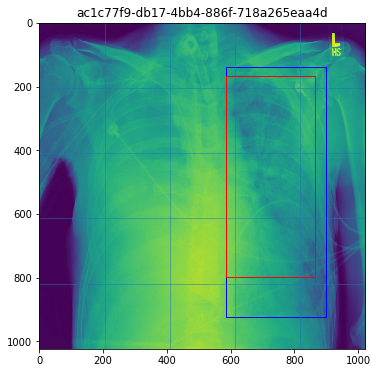

True: 0 Pred: 0 Intersect: 0
IOU: 0.0


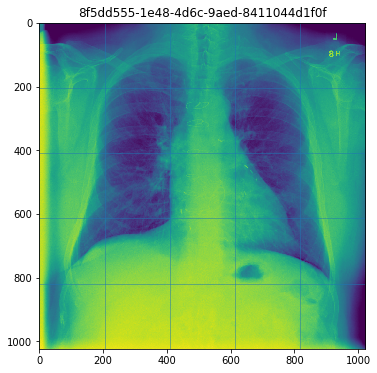

True: 0 Pred: 0 Intersect: 0
IOU: 0.0


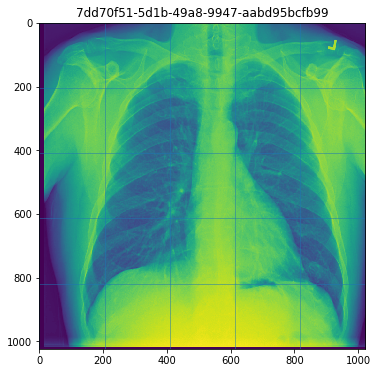

Pred: 2 3 conf: 0.95684135 577 232 262 477
True: 0 Pred: 124974 Intersect: 0
IOU: 0.0


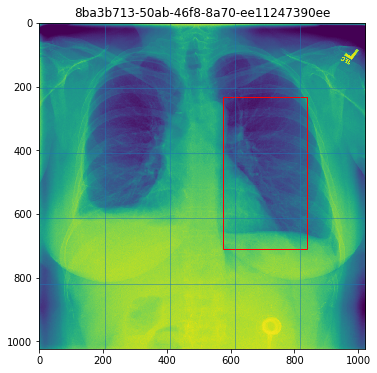

Pred: 2 3 conf: 0.9249164 645 381 223 278
True: 0 Pred: 61994 Intersect: 0
IOU: 0.0


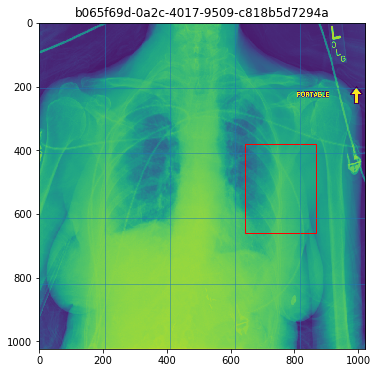

Truth: 2 3 617 305 179 222
Pred: 2 3 conf: 0.94493514 597 294 248 386
True: 39738 Pred: 95728 Intersect: 39738
IOU: 0.41511365535250805


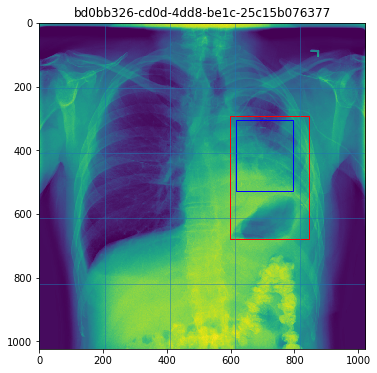

Pred: 1 1 conf: 0.94966084 188 96 254 458
True: 0 Pred: 116332 Intersect: 0
IOU: 0.0


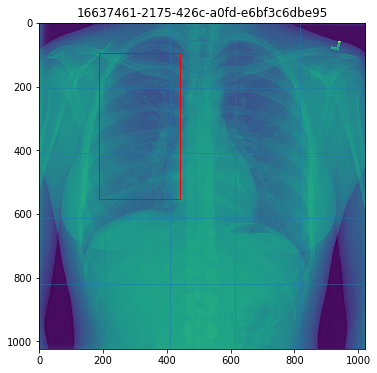

Truth: 2 1 274 343 162 461
Truth: 3 3 600 578 173 294
Pred: 1 1 conf: 0.9062669 205 175 220 286
Pred: 2 1 conf: 0.90921485 173 261 247 522
Pred: 2 3 conf: 0.9257528 599 287 252 520
True: 125544 Pred: 259974 Intersect: 103857
IOU: 0.36873049516841616


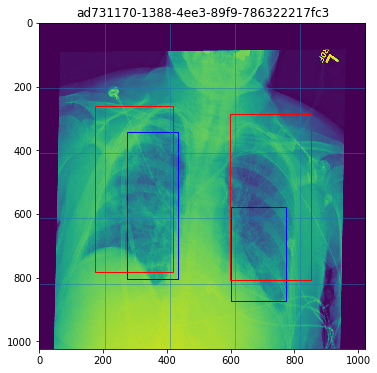

Overall Mean IOU: 0.09965061444622446


In [28]:
THRESHOLD = 0.90
OVERLAP = 0.4
# look at some sample predictions
# samples = np.random.choice(valid_filenames, size=15, replace=False)
# samples = problem_names

coords = np.arange(0, 1024, CELL_SIZE)
overall_ious = []

for filename in samples:
    # load the image
    img = pydicom.dcmread(os.path.join(train_dicom_dir, filename)).pixel_array
    
    filename = filename.split('.')[0]
    
    f, ax = plt.subplots(figsize=(6, 6))
    plt.imshow(img)
    
    # initialize our lists
    ious = []
    truths = []
    boxes = []
    
    # draw the truth boxes
    if filename in pneumonia_locations:
        locs = pneumonia_locations[filename].copy()
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                pixel_data = locs[i,j,:]
                if pixel_data[0] > 0.5:
                    x, y, w, h = pixel_data[1:]
                    
                    # unnormalize the data
                    w = w * 1024
                    h = h * 1024
                    
                    x = unnorm(x, j, CELL_SIZE)
                    y = unnorm(y, i, CELL_SIZE)
                    
                    # get the corners
                    x = x - (w // 2)
                    y = y - (h // 2)
                    
                    x = int(x)
                    y = int(y)
                    w = int(w)
                    h = int(h)
                    locs[i,j,:] = [1, x, y, w, h]
                    print("Truth:", i, j, x, y, w, h)
                    truths.append([x, y, w, h])
                    
                    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='b',facecolor='none')
                    ax.add_patch(rect)
                    
    # predict the image
    img = resize(img, (IMAGE_SIZE, IMAGE_SIZE), mode='reflect')
    yhat = model.predict(img.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1))
    yhat = sigmoid(yhat)
    conf = np.squeeze(yhat)[:,:,0]
    bboxes = np.squeeze(yhat)[:,:,1:]    
    pred_boxes = np.zeros_like(bboxes)
#     print(conf)

    # loop through our predictions
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            conf_ = conf[i,j]
            # if we have a prediction
            if conf_ > THRESHOLD:
                x,y,w,h = bboxes[i,j,:]
                
                # unnormalize the data
                w = w * 1024
                h = h * 1024

                x = unnorm(x, j, CELL_SIZE)
                y = unnorm(y, i, CELL_SIZE)
                
                # convert to upper left corner from center
                x = np.maximum(x - (w // 2), 0)
                y = np.maximum(y - (h // 2), 0)
                
                x = int(x)
                y = int(y)
                w = int(w)
                h = int(h)
                
                pred_boxes[i,j,:] = [x, y, w, h]
                
                print("Pred:", i, j, "conf:", conf_, x, y, w, h)
                
                # if the boxes have width and height add them to our list
                if w > 30 and h > 30:
                    boxes.append([x,y,w,h])
                
    # do non-max suppression of our boxes
    nms_boxes = non_max_suppression_fast(np.array(boxes), OVERLAP)
#     nms_boxes = boxes
    
    # plot our boxes
    for box in nms_boxes:
        x,y,w,h = box
#         print(x, y, w, h)
        rect = patches.Rectangle((x,y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    ## calculate the IOU
    true_area = 0
    # get the area of the true boxes
    for true_box in truths:
        x, y, w, h = true_box
        area = w * h
        true_area += area
        
    pred_area = 0
    # get the area of the predictions
    for pred_box in nms_boxes:
        x, y, w, h = pred_box
        area = w * h
        pred_area += area
        
    overall_intersect_area = 0
    # get the IOU by checking all combinations of boxes
    for true_box in truths:
        x1_t, y1_t, w_t, h_t = true_box
        for pred_box in nms_boxes:
            x1_p, y1_p, w_p, h_p = pred_box
            
            # get the far corners
            x2_p, y2_p = x1_p + w_p, y1_p + h_p
            x2_t, y2_t = x1_t + w_t, y1_t + h_t
        
            # get corners of intersection
            x1_i = np.maximum(x1_p, x1_t)
            y1_i = np.maximum(y1_p, y1_t)
            x2_i = np.minimum(x2_p, x2_t)
            y2_i = np.minimum(y2_p, y2_t)

            # get area of intersect
            i_w, i_h = x2_i - x1_i, y2_i - y1_i
            
            # trap for negative numbers
            i_w = np.maximum(i_w, 0)
            i_h = np.maximum(i_h, 0)
            
            intersect_area = i_w * i_h
            overall_intersect_area += intersect_area
            
    for item in coords:
        plt.axvline(item, linewidth=0.5)
        plt.axhline(item, linewidth=0.5)
    
    print("True:", true_area, "Pred:", pred_area, "Intersect:", overall_intersect_area)
    union_area = true_area + pred_area - overall_intersect_area
    
    iou = overall_intersect_area / (union_area + 1e-6)
    print("IOU:", iou)
    
    overall_ious.append(iou)
    plt.title(filename)
    plt.show()
    
print("Overall Mean IOU:", np.mean(overall_ious))    

# Predict test images

In [29]:
THRESHOLD = 0.5

# load and shuffle filenames
folder = './stage_1_test_images'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=3, image_size=IMAGE_SIZE, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    
    # predict batch of images
    yhats = model.predict(imgs)
    
    # apply sigmoid
    yhats = sigmoid(yhats)
    
    # loop through batch
    for yhat, filename in zip(yhats, filenames):
        predictionString = ""
        boxes = []
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                conf = yhat[i, j, 0]
                if conf > THRESHOLD:
                    x, y, w, h = yhat[i,j, 1:]
                    
                    # possible thresholds to keep our boxes within reasonable sizes?
                    if True: #w < 600 and h < 1000:
                        w = w * 1024
                        h = h * 1024

                        x = unnorm(x, j, CELL_SIZE)
                        y = unnorm(y, i, CELL_SIZE)

                        # convert to upper left corner from center
                        x = x - (w // 2)
                        y = y - (h // 2)
                        
                        if w > 20 and h > 20:
                            # make sure our boxes don't run off the edges of the images
                            w = np.minimum(w, 1024 - x)
                            h = np.minimum(h, 1024 - y)
                            boxes.append([x,y,w,h])

        # do our non-max suppression here
        boxes = non_max_suppression_fast(np.array(boxes), 0.3)
        
        # loop through our suppressed boxes and creat the prediction string
        for box in boxes:
            x,y,w,h = box
            
            x = int(x)
            y = int(y)
            w = int(w)
            h = int(h)
        
            # create the prediction string
            predictionString += str(0.9) + ' ' + str(x) + ' ' + str(y) + ' ' + str(w) + ' ' + str(h) + ' '
            
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString

    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break
    
# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']

now = datetime.datetime.now()
today = str(now)[:10]
submission_file = today + "_yolo_submission.csv" 
sub.to_csv(submission_file)

n test samples: 1000


/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [30]:
!kaggle competitions submit -c rsna-pneumonia-detection-challenge -f {submission_file} -m "YOLOv15 480x480 50 epochs"

Successfully submitted to RSNA Pneumonia Detection Challenge

In [ ]:
# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}
!gsutil cp ./{CHECKPOINT_PATH} gs://{bucket_name}/